In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [77]:
df = pd.read_csv('bank-full.csv', delimiter=';')

In [78]:
all_columns = df.columns
all_columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [79]:
# Specify the columns you want to exclude
exclude_columns = ['default', 'loan']

In [80]:
# Use list comprehension to create a new list excluding the unwanted columns
selected_columns = [col for col in all_columns if col not in exclude_columns]
selected_columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [81]:
selected_columns = df[selected_columns]

In [82]:
# Get numerical columns
numerical = selected_columns.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get categorical columns
categorical = selected_columns.select_dtypes(include=['object', 'category']).columns.tolist()

# Display the results
print("Numerical Columns:", numerical)
print("Categorical Columns:", categorical)


Numerical Columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical Columns: ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome', 'y']


In [83]:
from sklearn.model_selection import train_test_split

# First, split into train and temp (validation + test)
df_train, temp = train_test_split(df, test_size=0.4, random_state=1)

# Then, split temp into validation and test
df_val, df_test = train_test_split(temp, test_size=0.5, random_state=1)

# Check the sizes of the splits
print(f"Training set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")


Training set: 27126 samples
Validation set: 9042 samples
Test set: 9043 samples


In [84]:
from sklearn.metrics import roc_auc_score

def calculate_auc(df_train, numerical_columns, target_column='y'):
    # Initialize a dictionary to store AUC values
    auc_values = {}

    # Calculate AUC for each numerical column
    for col in numerical_columns:
        if col in df_train:  # Ensure the column exists in the training set
            # Calculate AUC
            auc = roc_auc_score(df_train[target_column], df_train[col])

            # If AUC < 0.5, negate the variable
            if auc < 0.5:
                auc = roc_auc_score(df_train[target_column], -df_train[col])

            # Store the AUC value
            auc_values[col] = auc

    return auc_values

# Now, use the function to calculate AUC for your training dataset
auc_results = calculate_auc(df_train, numerical_columns)

# Find the column with the highest AUC value
highest_auc_col = max(auc_results, key=auc_results.get)
highest_auc_value = auc_results[highest_auc_col]

# Display results
print("AUC Values:", auc_results)
print("Column with highest AUC:", highest_auc_col, "with AUC:", highest_auc_value)


AUC Values: {'age': np.float64(0.5125105881599707), 'balance': np.float64(0.5916931412945473), 'day': np.float64(0.5291275984648961), 'duration': np.float64(0.8128648066681694), 'campaign': np.float64(0.5742447701740003), 'pdays': np.float64(0.5897967289320412), 'previous': np.float64(0.5986704105715122)}
Column with highest AUC: duration with AUC: 0.8128648066681694


In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
import numpy as np

def train_and_evaluate(df_train, df_val):
    # Prepare the data for training
    y_train = df_train['y'].values
    dicts_train = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    # One-Hot Encoding
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts_train)

    # Train the Logistic Regression Model with regularization
    model = LogisticRegression(solver='liblinear', C=0.1, max_iter=1000)  # Reduced C value for regularization
    model.fit(X_train, y_train)

    # Evaluate using cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print("Cross-validated AUC scores:", cv_scores)
    print("Mean AUC from cross-validation:", np.mean(cv_scores))

    # Prepare validation data
    y_val = df_val['y'].values
    dicts_val = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
    X_val = dv.transform(dicts_val)

    # Make predictions and calculate AUC
    y_pred_prob = model.predict_proba(X_val)[:, 1]  # Probability estimates for the positive class
    auc = roc_auc_score(y_val, y_pred_prob)

    return round(auc, 3)

# Calculate AUC on the validation dataset
auc_value = train_and_evaluate(df_train, df_val)
print("AUC on validation dataset:", auc_value)

# Train and Evaluate your Model (from previous steps)
auc_value = train_and_evaluate(df_train, df_val)
print("AUC on validation dataset:", auc_value)

Cross-validated AUC scores: [1.         1.         0.99999967 1.         1.        ]
Mean AUC from cross-validation: 0.9999999345143882
AUC on validation dataset: 1.0
Cross-validated AUC scores: [1.         1.         0.99999967 1.         1.        ]
Mean AUC from cross-validation: 0.9999999345143882
AUC on validation dataset: 1.0


C:\Users\LENOVO\OneDrive\Desktop\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


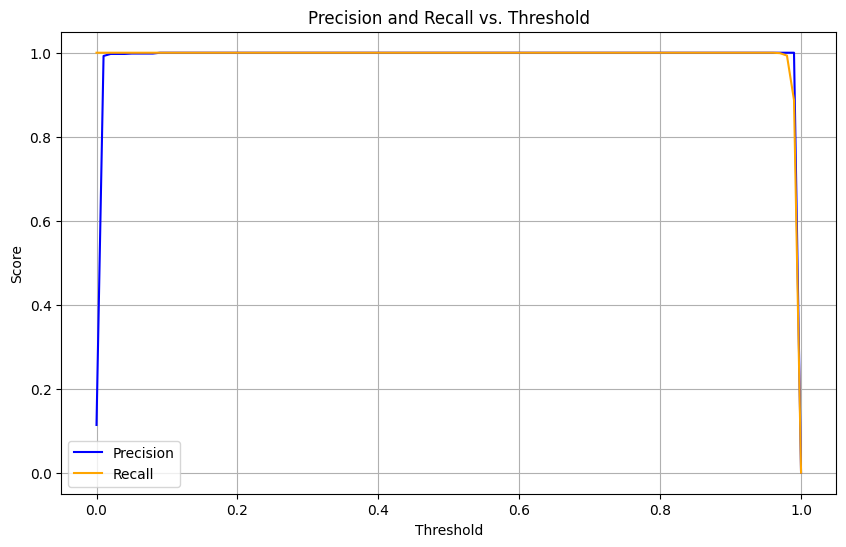

Intersection Threshold: 0.01


In [93]:
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer

def compute_precision_recall_thresholds(model, X_val, y_val):
    # Get predicted probabilities for the positive class
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.arange(0.0, 1.01, 0.01)  # Thresholds from 0.0 to 1.0
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # Calculate precision and recall for each threshold
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        
        precisions.append(precision)
        recalls.append(recall)
    
    return thresholds, precisions, recalls

# Assuming you already trained your model in the previous step
y_val = df_val['y'].values
dicts_val = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(dicts_val)

# Convert 'yes'/'no' labels in y_val to binary 0/1
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val).ravel()  # Convert to binary labels

# Now compute precision and recall using the modified y_val_bin
thresholds, precisions, recalls = compute_precision_recall_thresholds(model, X_val, y_val_bin)

# Plotting Precision and Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

# Find intersection point where precision and recall are close
intersection = np.argwhere(np.isclose(precisions, recalls, atol=0.01)).flatten()
if intersection.size > 0:
    intersection_threshold = thresholds[intersection[0]]
else:
    intersection_threshold = None

print("Intersection Threshold:", intersection_threshold)


C:\Users\LENOVO\OneDrive\Desktop\ML\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


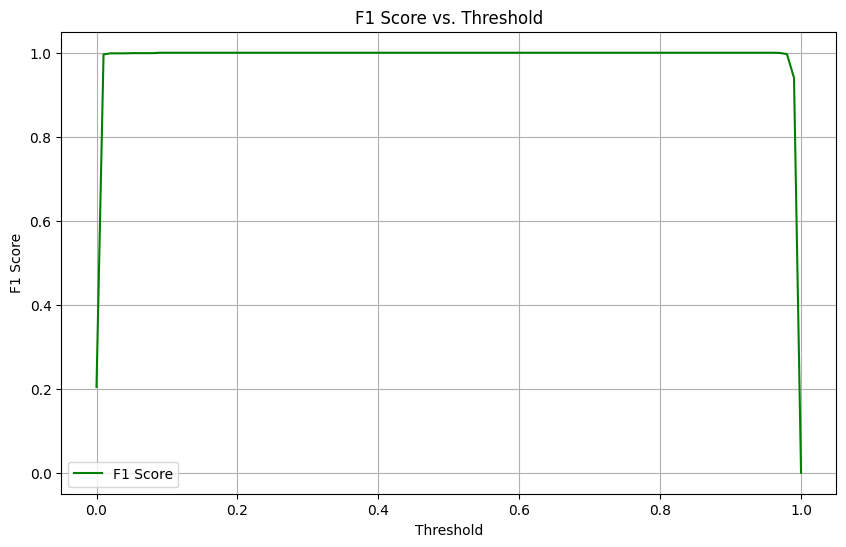

Max F1 Score: 1.0 at Threshold: 0.09


In [98]:
from sklearn.metrics import f1_score

def compute_f1_thresholds(model, X_val, y_val_bin):
    # Get predicted probabilities for the positive class
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.arange(0.0, 1.01, 0.01)  # Thresholds from 0.0 to 1.0
    f1_scores = []
    
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # Calculate precision and recall
        precision = precision_score(y_val_bin, y_pred)
        recall = recall_score(y_val_bin, y_pred)
        
        # Calculate F1 score
        f1 = f1_score(y_val_bin, y_pred)
        f1_scores.append(f1)
    
    return thresholds, f1_scores

# Compute F1 scores
thresholds, f1_scores = compute_f1_thresholds(model, X_val, y_val_bin)

# Plotting F1 Score vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

# Find the threshold where F1 is maximal
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1_value = f1_scores[max_f1_index]

print(f"Max F1 Score: {max_f1_value} at Threshold: {max_f1_threshold}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Assuming df_full_train is your full training DataFrame and y is the target variable
X = df_train.drop(columns='y').values  # Features
y = df_train['y'].values  # Target

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores
auc_scores = []

# Perform 5-Fold CV
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_prob)
    auc_scores.append(auc)

# Calculate standard deviation of the AUC scores
std_dev = np.std(auc_scores)

print(f"AUC scores across folds: {auc_scores}")
print(f"Standard deviation of AUC scores: {std_dev}")
